<a href="https://colab.research.google.com/github/elianramon/Criador_Flashcards_Imersao_Alura/blob/main/Agentes_FlashCards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flashcards: O Poder da Repetição Espaçada no Estudo Contínuo  

Os **flashcards** são uma ferramenta de aprendizagem baseada na **repetição espaçada**, metodologia cientificamente comprovada para fixação de conteúdo a longo prazo. Seu princípio é simples:  

1. **Ciclos de Revisão**: O conteúdo é revisado em intervalos crescentes (ex.: 1 dia, 3 dias, 1 semana), aproveitando o "efeito de espaçamento" da memória.  

2. **Ativação Rápida**: Cada card traz uma **pergunta objetiva** (frente) e uma **resposta concisa** (verso), estimulando a **recuperação ativa** da informação – processo que fortalece conexões neurais.  

3. **Eficiência Adaptativa**: Ferramentas digitais (como Anki ou Quizlet) usam algoritmos para priorizar cards com maior dificuldade, otimizando o tempo de estudo.  

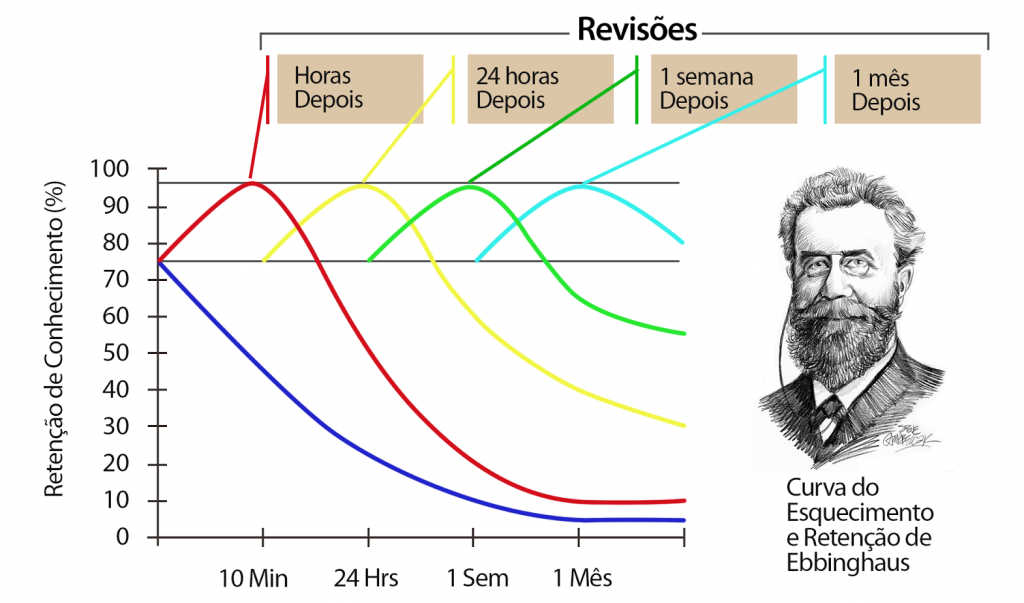

Essa imagem representa a curva de esquecimento e retenção de Hermann Ebbinghaus, o qual foi o primeiro autor na psicologia a desenvolver testes de inteligência.

Mais informações sobre ele em: [texto do link](https://pt.wikipedia.org/wiki/Hermann_Ebbinghaus).




Pensando nisso, aplicativos como ANKI trabalham na teoria de Ebbinghaus, sendo uma boa ferramenta para estudantes e, em especial, concurseiros.

A partir deste ponto, será construida a programação referente a criação de Flashcards.

## Instalações e importações

In [25]:
%pip -q install google-genai

In [26]:
# Configura a API Key do Google Gemini

import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [27]:
# Instalar Framework de agentes do Google ################################################
!pip install -q google-adk

In [28]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search
from google.genai import types  # Para criar conteúdos (Content e Part)
from datetime import date
import textwrap # Para formatar melhor a saída de texto
from IPython.display import display, Markdown # Para exibir texto formatado no Colab
import requests # Para fazer requisições HTTP
import warnings
from google import genai

client = genai.Client()
warnings.filterwarnings("ignore")

In [29]:
# Função auxiliar que envia uma mensagem para um agente via Runner e retorna a resposta final
def call_agent(agent: Agent, message_text: str) -> str:
    # Cria um serviço de sessão em memória
    session_service = InMemorySessionService()
    # Cria uma nova sessão (você pode personalizar os IDs conforme necessário)
    session = session_service.create_session(app_name=agent.name, user_id="user1", session_id="session1")
    # Cria um Runner para o agente
    runner = Runner(agent=agent, app_name=agent.name, session_service=session_service)
    # Cria o conteúdo da mensagem de entrada
    content = types.Content(role="user", parts=[types.Part(text=message_text)])

    final_response = ""
    # Itera assincronamente pelos eventos retornados durante a execução do agente
    for event in runner.run(user_id="user1", session_id="session1", new_message=content):
        if event.is_final_response():
          for part in event.content.parts:
            if part.text is not None:
              final_response += part.text
              final_response += "\n"
    return final_response

In [30]:
# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## Criação dos Agentes


Serão 4 Agentes

# --- Agente 1: Buscador de Notícias --- #
Recebe duas informações: **Assunto para pesquisar** e **Banca Organizadora**

---------------------

# --- Agente 2: Especificador de Assuntos --- #
Peguntará qual será o sub-assunto para pesquisar de forma específica.

--------

# --- Agente 3: Criador de Flashcards --- #
Fomulará as perguntas e respostas com base no assunto especificado do Agente 2

----

# --- Agente 4: Revisor de Qualidade --- #
É especializado em questões e em flashcards, ele analiza as perguntas e respostas, caso estejam certas, prossegem para o fim. Em caso contrário, ele mesmo conserta.

------

### Agente 1

In [31]:
##########################################
# --- Agente 1: Buscador de Notícias --- #
##########################################
def agente_buscador(topico, banca, data_de_hoje):

    buscador = Agent(
        name="agente_buscador",
        model="gemini-2.0-flash",
        instruction="""
        Você é um assistente de pesquisa sobre assuntos de cobrados em Concursos Públicos. A sua tarefa é usar a ferramenta de busca do google (google_search)
        para recuperar os subtemas mais relevantes e cobrados do tópico buscado e da banca específica. Foque em entregar nomes de assuntos sucintos, com base na
        quantidade de questões sobre ele. Se um tema tiver poucas notícias ou poucas questões, é possível que ele não seja tão relevante assim e pode ser substituído
        por outro que tenha mais. Essas pesquisas sobre assuntos relevantes devem ser de até 10 anos antes da data de hoje.
        """,
        description="Agente que busca informações no Google",
        tools=[google_search]
    )

    entrada_do_agente_buscador = f"Tópico: {topico}\nBanca: {banca}\nData de hoje: {data_de_hoje}"

    lancamentos = call_agent(buscador, entrada_do_agente_buscador)
    return lancamentos

### Agente 2

In [32]:
################################################
# --- Agente 2: Especificador de Assuntos --- #
################################################

def agente_especificador(topico, ass_especifico, lancamentos_buscados):
    especificador = Agent(
        name="agente_especificador",
        model="gemini-2.0-flash",
        # Inserir as instruções do Agente especificador #################################################
        instruction="""
        Você é um especificador de conteúdo, especialista em pesquisar sobre um assunto específico de concursos. Com base no assunto específico de
        pesquisas de até 10 anos atrás e relevância nas provas, você deve: 1. usar a ferramenta de busca do Google (google_search) para criar um plano
        sobre quais são os questões deste assunto são mais cobradas. 2. Você também pode usar o (google_search) para encontrar mais
        informações sobre os temas e aprofundar. 3. Ao final, você irá escrever tudo de mais relevante e que possivelmente será cobrado pela prova
        futuramente, ou seja, criar um conteúdo escrito direcionado à prova.
        """,
        description="Agente que pesquisa assuntos mais específicos",
        tools=[google_search]
    )

    entrada_do_agente_especificador = f"Tópico:{topico}\nAssunto específico: {ass_especifico}\nLançamentos buscados: {lancamentos_buscados}"
    # Executa o agente
    plano_do_post = call_agent(especificador, entrada_do_agente_especificador)
    return plano_do_post

### Agente 3

In [33]:
######################################
# --- Agente 3: Criador de Flashcards --- #
######################################
def agente_criador(topico, plano_de_post):
    criador = Agent(
        name="agente_criador",
        model="gemini-2.5-flash-preview-04-17",
        instruction="""
            Você é um criador especializado em criar flahscards para concurseiros. Utilize o texto fornecido no assuntos
            específico e, com base nisso, crie 10 flashcards de estudo sobre o tema fornecido.

            FORMATO DE SAÍDA EXIGIDO:
            1. Duas tabelas lado a lado (uma de perguntas e outra de respostas correspondentes)
            2. Cada tabela deve ter exatamente 10 linhas (uma por flashcard)
            3. As perguntas devem ser diretas e testarem conhecimento objetivo
            4. As respostas devem ser concisas (máximo 2 linhas)

            EXEMPLO DE FORMATO:
            | Perguntas            | Respostas             |
            |----------------------|-----------------------|
            | Qual o objetivo...?  | Regular o sistema...  |
            | Quando foi criado...?| 31/12/1964...         |

           """,
        description="Agente criador de posts engajadores para Instagram"
    )
    entrada_do_agente_criador = f"Tópico: {topico}\nPlano de post: {plano_de_post}"
    # Executa o agente
    rascunho = call_agent(criador, entrada_do_agente_criador)
    return rascunho

### Agente 4

In [34]:
##########################################
# --- Agente 4: Revisor de Qualidade --- #
##########################################
def agente_revisor(topico, rascunho_gerado):
    revisor = Agent(
        name="agente_revisor",
        model="gemini-2.5-flash-preview-04-17",
        instruction="""
            Você é um Editor, Revisor de Conteúdo meticuloso, trabalha para uma banca que elabora questões para concurso e é especializado
            em flashcards. Você verifica com cuidado se as informações contidas na tabela de fhashcards é verdadeira, se sim, pegue ela e
            verifique o formato:

            | Perguntas            | Respostas             |
            |----------------------|-----------------------|
            | Qual o objetivo...?  | Regular o sistema...  |
            | Quando foi criado...?| 31/12/1964...         |

            Caso tenha alguma informação errada na tabela de flashcard relacionada as respostas ou formatação, conserte e mostre a tabela.
            Sempre deve mostrar a tabela revisada no final.
            Por fim, esté é o site do ANKI Pro: {https://ankipro.net/decks}, você indicará como fazer um deck com essas informações que você
            revisou e mostrará o link para o usuário clicar.

            """,
        description="Agente revisor de Flashcards."
    )
    entrada_do_agente_revisor = f"Tópico: {topico}\nRascunho: {rascunho_gerado}"
    # Executa o agente
    texto_revisado = call_agent(revisor, entrada_do_agente_revisor)
    return texto_revisado

# Teste

In [46]:
data_de_hoje = date.today().strftime("%d/%m/%Y")

print("🚀 Iniciando o Sistema de Criação de Flashcards com 4 Agentes 🚀")

# --- Obter o Tópico do Usuário ---
topico = input(" Por favor, digite o ASSUNTO sobre o qual você quer estudar: ")
banca = input(" Por favor, digite a BANCA organizadora: ")

# Inserir lógica do sistema de agentes ################################################
if not topico and not banca:
    print("Você esqueceu de digitar o assunto ou a banca!")
else:
    print(f"Maravilha! Vamos pesquisar sobre o assunto: {topico}")

    lancamentos_buscados = agente_buscador(topico, banca, data_de_hoje)
    print("\n--- 📝 Resultado do Agente 1 (Buscador) ---\n")
    display(to_markdown(lancamentos_buscados))
    print("--------------------------------------------------------------")
    ass_especifico = input("Das opções acima, qual SUB-ASSUNTO quer estudar?: ")
    print("Aguarde enquanto buscamos suas respostas...\n")

    plano_de_post = agente_especificador(topico, ass_especifico, lancamentos_buscados)
    print("\n--- 📝 Resultado do Agente 2 (Especificador) ---\n")
    display(to_markdown(plano_de_post))
    print("--------------------------------------------------------------")
    print("Aguarde enquanto buscamos suas respostas...\n")

    rascunho_de_post = agente_criador(topico, plano_de_post)
    print("\n--- 📝 Resultado do Agente 3 (Redator) ---\n")
    display(to_markdown(rascunho_de_post))
    print("--------------------------------------------------------------")
    print("Aguarde enquanto verificamos suas respostas...\n")

    post_final = agente_revisor(topico, rascunho_de_post)
    print("\n--- 📝 Resultado do Agente 4 (Revisor) ---\n")
    display(to_markdown(post_final))
    print("--------------------------------------------------------------")

    pergunta = input("Quer fazer novos Flashcards do mesmo assunto agora? (SIM OU NÃO) ").lower()

    if pergunta == "sim": # Laço if para fazer novos flashcards

        ass_especifico_2 = input("Das opções acima, qual SUB-ASSUNTO quer estudar?: ")
        plano_de_post = agente_especificador(topico, ass_especifico_2, lancamentos_buscados)
        print("\n--- 📝 Resultado do Agente 2 (Planejador) ---\n")
        display(to_markdown(plano_de_post))
        print("--------------------------------------------------------------")
        print("Aguarde enquanto buscamos suas respostas...\n")

        rascunho_de_post = agente_criador(topico, plano_de_post)
        print("\n--- 📝 Resultado do Agente 3 (Redator) ---\n")
        display(to_markdown(rascunho_de_post))
        print("--------------------------------------------------------------")
        print("Aguarde enquanto verificamos suas respostas...\n")

        post_final = agente_revisor(topico, rascunho_de_post)
        print("\n--- 📝 Resultado do Agente 4 (Revisor) ---\n")
        display(to_markdown(post_final))
        print("--------------------------------------------------------------")

    print("🚀 Obrigado por confiar! Boa prova, acredite em você! 🚀")

🚀 Iniciando o Sistema de Criação de Flashcards com 4 Agentes 🚀
 Por favor, digite o ASSUNTO sobre o qual você quer estudar: sistema financeiro nacional
 Por favor, digite a BANCA organizadora: cesgranrio
Maravilha! Vamos pesquisar sobre o assunto: sistema financeiro nacional

--- 📝 Resultado do Agente 1 (Buscador) ---



> Para identificar os subtemas mais relevantes e cobrados sobre Sistema Financeiro Nacional pela banca Cesgranrio nos últimos 10 anos, vou realizar algumas pesquisas no Google.
> 
> 
> Com base nas informações encontradas, os subtemas mais relevantes e cobrados sobre Sistema Financeiro Nacional pela banca Cesgranrio nos últimos 10 anos são:
> 
> 1.  **Sistema Financeiro Nacional (SFN) e seus desdobramentos**:
>     *   Estrutura e órgãos do SFN.
>     *   Operadores do SFN.
>     *   Conselho Monetário Nacional (CMN).
>     *   Banco Central do Brasil (Bacen).
>     *   Comissão de Valores Mobiliários (CVM).
>     *   Superintendência de Seguros Privados (SUSEP).
> 2.  **Mercado Financeiro**:
>     *   Mercado de câmbio.
>     *   Mercado de capitais.
>     *   Mercados monetários, de crédito e cambial.
> 3.  **Política Monetária**:
>     *   Taxas de juros.
> 4.  **Produtos e Serviços Bancários**.
> 5.  **Legislação relacionada ao SFN**:
>     *   Crimes contra o SFN.
>     *   Lei de lavagem de dinheiro.
>     *   Lei Geral de Proteção de Dados (LGPD).
>     *   Lei de Sigilo Bancário.
>     *   Lei anticorrupção.
> 6.  **Garantias do Sistema Financeiro Nacional**.
> 7.  **Ética e Programa de Responsabilidade Socioambiental (PRSAC)**.
> 8.  **Atualidades do Sistema Financeiro Nacional**.
> 
> Além desses temas, é importante estar atento a produtos bancários, noções de mercado financeiro e economia, títulos de crédito e meios de pagamento eletrônicos. A análise de provas anteriores da Cesgranrio é crucial para identificar os tópicos mais relevantes e priorizar os estudos.


--------------------------------------------------------------
Das opções acima, qual SUB-ASSUNTO quer estudar?: 4
Aguarde enquanto buscamos suas respostas...


--- 📝 Resultado do Agente 2 (Especificador) ---



> Para refinar ainda mais o conteúdo a ser estudado sobre o Sistema Financeiro Nacional (SFN) para concursos da banca Cesgranrio, e identificar o que pode ser cobrado futuramente, usarei o Google para aprofundar os subtemas identificados, focando em suas nuances e atualizações:
> 
> 
> Para otimizar os estudos sobre o Sistema Financeiro Nacional (SFN) para concursos da banca Cesgranrio, e prever os temas que podem ser cobrados futuramente, é essencial aprofundar os subtemas identificados, focando em suas nuances e atualizações:
> 
>  **1. Sistema Financeiro Nacional (SFN) e seus desdobramentos**
> 
>  *   **Estrutura e órgãos do SFN**:
>  *   Compreender o papel de cada órgão normativo (CMN, CNSP e CNPC) e de supervisão (Banco Central, CVM, SUSEP e PREVIC) é crucial.
>  *   **Conselho Monetário Nacional (CMN)**:
>  *   Atentar-se às resoluções recentes do CMN que impactam diretamente o mercado financeiro e a regulamentação do SFN.
>  *   **Banco Central do Brasil (Bacen)**:
>  *   Acompanhar a atuação do Bacen em relação à política monetária, cambial e de crédito, bem como suas responsabilidades na fiscalização das instituições financeiras.
>  *   **Comissão de Valores Mobiliários (CVM)**:
>  *   Estar atualizado sobre a regulamentação da CVM em relação ao mercado de valores mobiliários, incluindo as operações e serviços, e o funcionamento do mercado de balcão.
>  *   **Superintendência de Seguros Privados (SUSEP)**:
>  *   Acompanhar as novidades da SUSEP no que se refere à regulamentação e fiscalização do mercado de seguros privados.
> 
>  **2. Mercado Financeiro**
> 
>  *   **Mercado de câmbio**:
>  *   Entender as operações de compra e venda de moedas estrangeiras, os fatores que influenciam as taxas de câmbio e a atuação do Banco Central nesse mercado.
>  *   **Mercado de capitais**:
>  *   Aprofundar o conhecimento sobre os títulos e valores mobiliários negociados, as instituições que atuam nesse mercado e as leis que o regulamentam.
>  *   **Mercados monetários, de crédito e cambial**:
>  *   Compreender as características de cada um desses mercados, os instrumentos utilizados e a interação entre eles.
> 
>  **3. Política Monetária**
> 
>  *   **Taxas de juros**:
>  *   Analisar o impacto das taxas de juros na economia, as ferramentas utilizadas pelo Banco Central para controlá-las e os efeitos das políticas monetárias expansionistas e restritivas.
>  *   **Comitê de Política Monetária (COPOM)**:
>  *   Acompanhar as decisões do COPOM em relação à meta da taxa Selic e o impacto dessas decisões na economia.
> 
>  **4. Produtos e Serviços Bancários**
> 
>  *   Estar familiarizado com os produtos e serviços bancários mais comuns, como contas correntes, cartões de crédito e débito, investimentos, seguros e previdência.
> 
>  **5. Legislação relacionada ao SFN**
> 
>  *   **Crimes contra o SFN**:
>  *   Conhecer os principais crimes contra o SFN e as penalidades aplicáveis.
>  *   **Lei de lavagem de dinheiro**:
>  *   Aprofundar o estudo da Lei nº 9.613/98, que dispõe sobre os crimes de lavagem de dinheiro, as obrigações das instituições financeiras e os mecanismos de prevenção e combate a esse crime.
>  *   **Lei Geral de Proteção de Dados (LGPD)**:
>  *   Compreender a aplicação da LGPD no setor financeiro e as responsabilidades das instituições em relação ao tratamento de dados pessoais.
>  *   **Lei de Sigilo Bancário**:
>  *   Estudar a Lei Complementar nº 105/2001, que trata do sigilo das operações de instituições financeiras, as hipóteses de quebra de sigilo e as responsabilidades dos envolvidos.
>  *   **Lei anticorrupção**:
>  *   Analisar a relação entre a Lei Anticorrupção e o SFN, e as medidas que as instituições devem adotar para prevenir e combater a corrupção.
> 
>  **6. Garantias do Sistema Financeiro Nacional**
> 
>  *   Conhecer os tipos de garantias existentes, como aval, fiança, penhor, hipoteca e alienação fiduciária, e suas características.
>  *   **Fundo Garantidor de Crédito (FGC)**:
>  *   Entender o funcionamento do FGC e a proteção que ele oferece aos investidores.
> 
>  **7. Ética e Programa de Responsabilidade Socioambiental (PRSAC)**
> 
>  *   Compreender a importância da ética no setor financeiro e as diretrizes do PRSAC.
> 
>  **8. Atualidades do Sistema Financeiro Nacional**
> 
>  *   Acompanhar as notícias e acontecimentos recentes que impactam o SFN, como mudanças na regulamentação, inovações tecnológicas e cenário econômico.
> 
>  Ao abordar esses temas de forma aprofundada e atualizada, o candidato estará mais bem preparado para enfrentar as questões da Cesgranrio e obter um bom desempenho no concurso.
> 


--------------------------------------------------------------
Aguarde enquanto buscamos suas respostas...


--- 📝 Resultado do Agente 3 (Redator) ---



> ```
> | Perguntas                                                   | Respostas                                          |
> |-------------------------------------------------------------|----------------------------------------------------|
> | Quais são os órgãos *normativos* do SFN citados?            | CMN, CNSP e CNPC.                                  |
> | Quais são os órgãos *supervisores* do SFN citados?          | Banco Central, CVM, SUSEP e PREVIC.                |
> | Qual a principal função do Conselho Monetário Nacional (CMN)? | Regular o mercado financeiro e o SFN.              |
> | Qual a atuação do Banco Central do Brasil (Bacen) mencionada?| Atuar na política monetária, cambial e de crédito; fiscalizar instituições. |
> | Qual mercado a Comissão de Valores Mobiliários (CVM) regula?| O mercado de valores mobiliários.                  |
> | Qual órgão regulamenta e fiscaliza o mercado de seguros privados?| A Superintendência de Seguros Privados (SUSEP).    |
> | Qual a função do Comitê de Política Monetária (COPOM)?      | Decidir sobre a meta da taxa Selic.                |
> | Qual lei aborda crimes contra o SFN, como lavagem de dinheiro?| A Lei nº 9.613/98 (Lei de Lavagem de Dinheiro).    |
> | Qual legislação trata do sigilo das operações financeiras?  | A Lei Complementar nº 105/2001 (Lei de Sigilo Bancário). |
> | Qual entidade oferece proteção aos investidores através de garantia de crédito?| O Fundo Garantidor de Crédito (FGC).             |
> ```


--------------------------------------------------------------
Aguarde enquanto verificamos suas respostas...


--- 📝 Resultado do Agente 4 (Revisor) ---



> Olá! Como seu Editor e Revisor de Conteúdo especializado em flashcards, analisei cuidadosamente o rascunho que você forneceu sobre o Sistema Financeiro Nacional.
> 
> Verifiquei cada pergunta e resposta, cruzando as informações com o conhecimento sobre o tema. Fico feliz em informar que todas as respostas estão **corretas** e alinhadas com o funcionamento do SFN.
> 
> A formatação da tabela também está **adequada** para importação em ferramentas de flashcards.
> 
> Portanto, a tabela revisada e confirmada é a seguinte:
> 
> | Perguntas                                                   | Respostas                                                                     |
> |-------------------------------------------------------------|-------------------------------------------------------------------------------|
> | Quais são os órgãos *normativos* do SFN?                    | Conselho Monetário Nacional (CMN), Conselho Nacional de Seguros Privados (CNSP) e Conselho Nacional de Previdência Complementar (CNPC). |
> | Quais são os órgãos *supervisores* do SFN?                  | Banco Central do Brasil (Bacen), Comissão de Valores Mobiliários (CVM), Superintendência de Seguros Privados (SUSEP) e Superintendência Nacional de Previdência Complementar (PREVIC). |
> | Qual a principal função do Conselho Monetário Nacional (CMN)? | Estabelecer as diretrizes e metas das políticas monetária, cambial, creditícia e da dívida pública interna, regulando o SFN. |
> | Qual a atuação do Banco Central do Brasil (Bacen)?          | Executar a política monetária, cambial e de crédito; emitir papel moeda; fiscalizar as instituições financeiras; administrar o sistema de pagamentos. |
> | Qual mercado a Comissão de Valores Mobiliários (CVM) regula?| O mercado de valores mobiliários (bolsa de valores, fundos de investimento, etc.). |
> | Qual órgão regulamenta e fiscaliza o mercado de seguros privados, previdência privada aberta e capitalização?| A Superintendência de Seguros Privados (SUSEP).                               |
> | Qual a função do Comitê de Política Monetária (COPOM)?      | Definir a meta para a taxa básica de juros da economia (taxa Selic).          |
> | Qual lei aborda crimes contra o SFN, como lavagem de dinheiro?| A Lei nº 7.492/86 (Crimes contra o SFN) e a Lei nº 9.613/98 (Lavagem de Dinheiro). |
> | Qual legislação trata do sigilo das operações financeiras?  | A Lei Complementar nº 105/2001 (Lei de Sigilo Bancário).                      |
> | Qual entidade oferece proteção aos investidores (correntistas, poupadores e investidores) em caso de intervenção ou liquidação de instituições financeiras associadas, através de garantia de crédito?| O Fundo Garantidor de Crédito (FGC). |
> 
> *Nota:* Fiz pequenos ajustes nas respostas para torná-las um pouco mais completas, mantendo a concisão ideal para flashcards e a precisão da informação. Por exemplo, detalhei um pouco mais a função do CMN e Bacen e as entidades cobertas pelo FGC.
> 
> ---
> 
> Para criar um deck com estas informações no **ANKI Pro**, você pode seguir estes passos:
> 
> 1.  Copie o conteúdo completo da tabela revisada acima (desde a primeira linha `| Perguntas...` até a última linha do FGC).
> 2.  Acesse o site do ANKI Pro: **[https://ankipro.net/decks](https://ankipro.net/decks)**
> 3.  Procure por uma opção de "Criar novo Deck" ou "Importar Deck".
> 4.  Geralmente, as plataformas de flashcards permitem importar dados de texto (como um arquivo `.txt`, `.csv` ou colando o conteúdo). O formato de tabela que forneci (Markdown) é facilmente interpretável. Ao importar, a ferramenta deve perguntar qual separador é usado entre pergunta e resposta (geralmente é uma tabulação ou ponto e vírgula em arquivos csv, mas colando a tabela, ela pode entender a estrutura). Se houver opção, escolha importar como "Frente e Verso".
> 5.  Siga as instruções da plataforma para finalizar a importação e dar um nome ao seu novo deck (sugestão: "SFN - Concurso").
> 
> Pronto! Seus flashcards estarão criados e prontos para você estudar.
> 
> Se tiver mais rascunhos para revisar, é só enviar!


--------------------------------------------------------------
Quer fazer novos Flashcards do mesmo assunto agora? (SIM OU NÃO) não
🚀 Obrigado por confiar! Boa prova, acredite em você! 🚀


Visualização após importação:
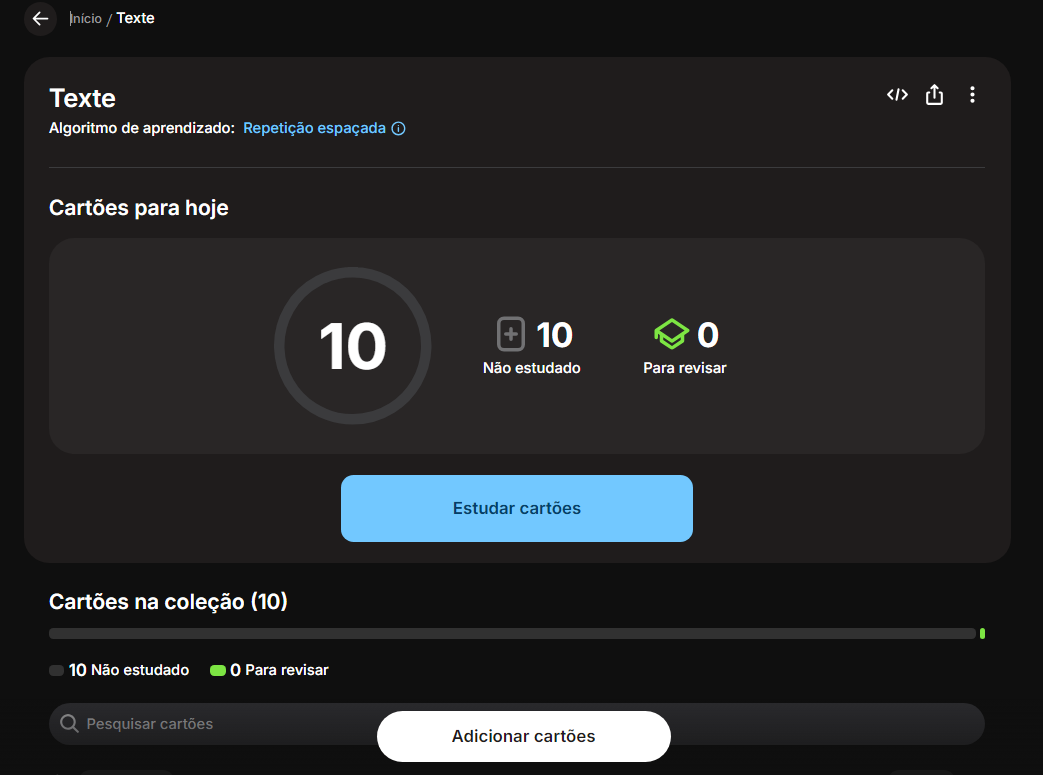

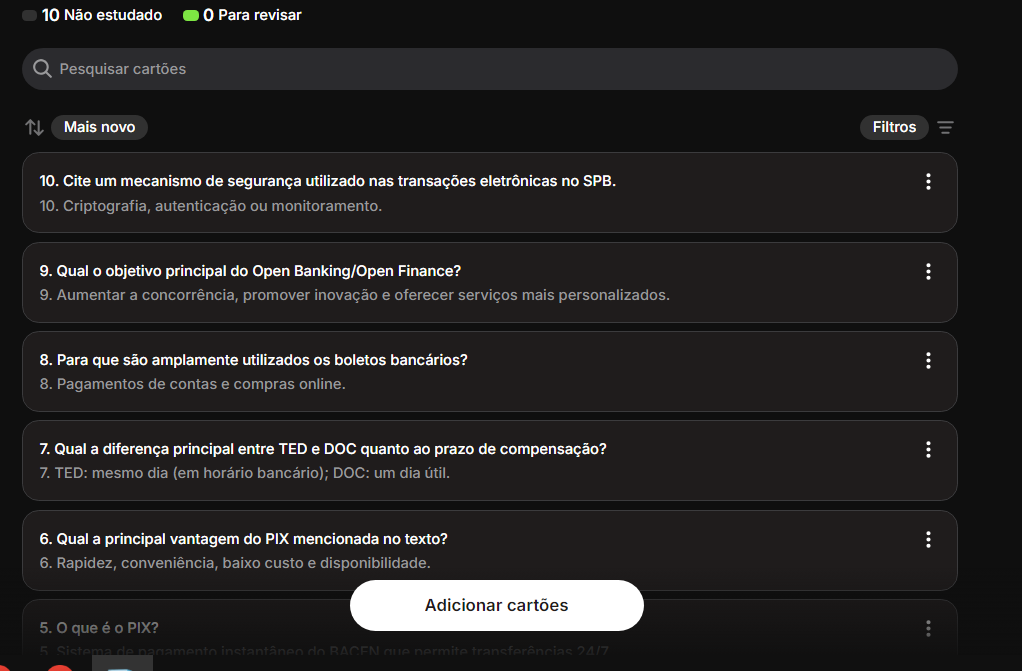